# Extracción de características

En este cuaderno se explora la extracción de características de las celdas de precipitación de manera sencilla. Veremos los conteos de núcleos de tormentas, su tamaño y hallaremos sus bordes.

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import wradlib as wrl
import skimage
import skimage.segmentation as segmentation
import matplotlib.patches as mpatches

import Bases_GUI as radar
import utilidades as util

import warnings
warnings.filterwarnings('ignore')

Como primer paso tendremos que llamar algunos datos. 

In [3]:
file = 'C:/Python37/Lluvia/2019051415200000dBuZ.azi'
radardata = radar.read_data(file)
dato = radardata.data['data']

Estos corresponden nuevamente a nuestro ejemplo de "Precipitación tipo 2". Si bien estos procesos se deben llevar a cabo sobre los datos procesados, a manera de ejemplo los haremos sobre los datos originales. No acople este proceso en una de las etapas iniciales de la cadena de procesamiento.

El conteo de características se puede realizar en los ejes cartesianos como el polares. En este cuaderno se aborda el procedimiento usando los datos sobre la proyección cartesiana. ¿Por que? Porque resulta más sencillo trabajar sobre la típica cuadrícula cartesiana que la polar(no habrá cambio de resolución en cada píxel y el trazado de objetos como círculos, elipses y rectángulos es mucho más sencillo). Sin embargo, si se desean hacer sobre los datos originales puede usarse un enfoque similar. 

Para ello necesitaremos proyectarlos en el plano cartesiano. 

In [120]:
azi, r = util.ejes()
r = r * 1000 
x200, y200 , grid200 = util.proyectar(dato, r, azi, res=200, ipol = wrl.ipol.Idw, mask=True)

Calculamos la imagen binaria.

In [121]:
binaria = grid200.copy()
binaria.mask = np.ma.nomask

In [122]:
# Usamos un threshold un poco más alto porque producto de la interpolación aparecerán valores que antes no existían
binaria = binaria > -30

Vemos los resultados

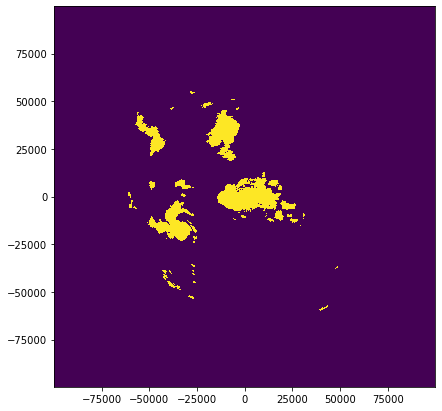

In [22]:
figure = plt.figure(figsize=(8,7))
ax = figure.add_subplot(111, aspect="equal")
pm = plt.pcolormesh(x200, y200, binaria)

Ya con los datos binarizados, el primer paso corresponde al etiquetado. En lugar de la función que hemos usado anteriormente **`label`** del módulo **`scipy.ndimage`** usaremos la que viene incluida en la librería **`skimage`**

In [232]:
label, nums = skimage.measure.label(binaria, return_num=True)

Veamos cuantos elementos existen

In [233]:
print('Número de elementos: {}'.format(nums))

Número de elementos: 72


Como es evidente que ningún humano contaría esa cantidad, tenemos que filtrar los elementos más pequeños. Pero antes veremos las características que se pueden obtener. 

In [225]:
props = skimage.measure.regionprops(label)

Vemos los resultados al graficar los centroides y rectángulos. 

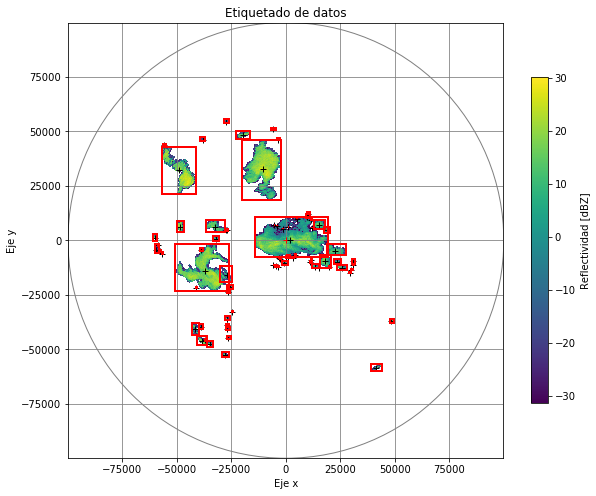

In [175]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
pm = ax.pcolormesh(x200, y200, grid200)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Etiquetado de datos')
plt.xlabel("Eje x")
plt.ylabel("Eje y")
plt.xlim(min(x200), max(x200))
plt.ylim(min(y200), max(y200))
plt.grid(color="grey")
plt.plot(0, 0, 'r+', zorder=5)
# Agregamos un círculo delimitador del alcance
circle = mpatches.Circle((0,0),100000., fill=False, edgecolor='gray', linewidth=1)
ax.add_patch(circle)
# Agregamos los rectángulos de los límites(facilmente se puede intercambiar por una elipse) 
for region in props:
    minr, minc, maxr, maxc = region.bbox
    minr = x200[int(minr)]
    maxr = x200[int(maxr)]
    minc = y200[int(minc)]
    maxc = y200[int(maxc)]
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2, zorder=6)
    ax.add_patch(rect)
# Agregamos el centroide de cada elemento
for region in props: 
    row, column = region.centroid
    row = x200[int(row)]
    column = y200[int(column)]
    plt.plot(column, row, 'k+', zorder=5)

**Nota:** Si los rectángulos nos parecen muy juntos, podemos agregar un factor de distanciamiento en píxeles a los valores de **`minr`**, **`maxr`**, **`minc`** y **`maxc`**. También es posible usar elipses usando  **`mpatches.Ellipse`** en lugar de **`mpatches.Rectangle`**. 

El resultado tal vez no nos complazca. Antes de cualquier comentario recuerde que estos datos no han sido procesados. Aún así, no nos tenemos que contentar con ellos, podemos aplicar nuestro filtro espacial para reducir el número de elementos. El número de estrategias que se pueden plantear solo se encuentra limitado por tu conocimiento e ideas. Adicionalmente al filtrado usaré un esquema de conectividad jerárquico. En cualquier caso esto puede ser un primer paso de cara al seguimiento de tormentas. 

Filtraremos por áreas. A diferencia del cuaderno de "Marcado espacial" no usaremos la función sino que veremos otras maneras de hacerlo usando la librería **`skimage`**.

In [268]:
area = np.array([region.area for region in props])
area

array([ 109,   84,   89,  165,    9,   35,  197,   22,   37,   19,   34,
         46,    7,   16, 5695,   62,    8,  208,    8,  163,    6,   96,
          8,  446,    4,   11,    4,    6,    6,   77,  106,   42,   14,
          3,    3,    6,    7,    5,   13, 9737,  622,    4,   12,  120,
         15,   19,   10,   75,   91,  116,  263,  610,    5,    5,    1,
        369,    2,    2,    1,    2,    2,    1,   57,   16, 6105, 2872,
         21,   49,   30,  241,   34,   54])

Filtramos los elementos más pequeños. Tomaré como pequeños todos aquellos menores que 100 elementos(número pseudo-arbitrario). 

In [275]:
mask = area < 100
indices = np.nonzero(mask)[0]
cami = label.copy()
for i in indices:
    # Se le suma uno porque los valores de etiquetas comienzan en uno y no desde cero como los índices. 
    cami[label == i+1] = 0
relab, fw, inv = segmentation.relabel_sequential(cami)
print('Nuevo número de etiquetas: {}'.format(relab.max()))

Nuevo número de etiquetas: 18


Con los nuevos datos repetimos el proceso. 

In [278]:
props2 = skimage.measure.regionprops(relab)
area2 = np.array([region.area for region in props2])
print('Area')
print(area2)

Area
[ 109  165  197 5695  208  163  446  106 9737  622  120  116  263  610
  369 6105 2872  241]


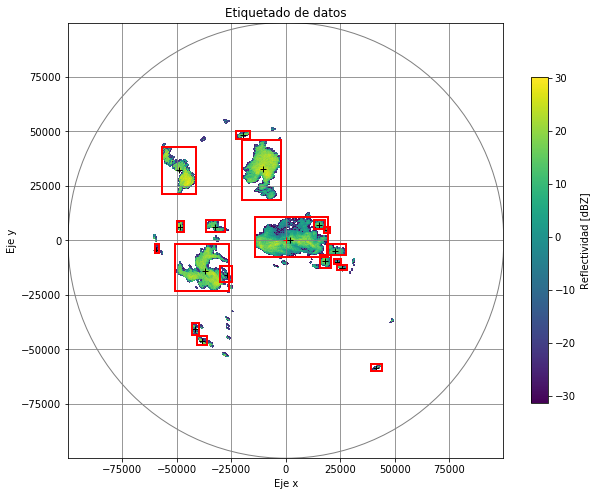

In [279]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
pm = ax.pcolormesh(x200, y200, grid200)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Etiquetado de datos')
plt.xlabel("Eje x")
plt.ylabel("Eje y")
plt.xlim(min(x200), max(x200))
plt.ylim(min(y200), max(y200))
plt.grid(color="grey")
plt.plot(0, 0, 'r+', zorder=5)
# Agregamos un círculo delimitador del alcance
circle = mpatches.Circle((0,0),100000., fill=False, edgecolor='gray', linewidth=1)
ax.add_patch(circle)
# Agregamos los rectángulos de los límites(facilmente se puede intercambiar por una elipse) 
for region in props2:
    minr, minc, maxr, maxc = region.bbox
    minr = x200[int(minr)]
    maxr = x200[int(maxr)]
    minc = y200[int(minc)]
    maxc = y200[int(maxc)]
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2, zorder=6)
    ax.add_patch(rect)
# Agregamos el centroide de cada elemento
for region in props2: 
    row, column = region.centroid
    row = x200[int(row)]
    column = y200[int(column)]
    plt.plot(column, row, 'k+', zorder=5)

En lo particular a mí me sigue pareciendo insatisfactorio, esto se debe a que se marcan elementos muy cercanos entre si, que un humano consideraría como una sola entidad. Es por ello que abordaremos el enfoque jerárquico. Para ello volvemos a trabajar con los datos originales.